第四题

In [28]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
from time import time
ds = LocalDataService()
## 加freq参数
start = time()
path = r'.\min_data\VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1Min,5Min,15Min,30Min,1H,4H,6H,8H,12H',
         'start_date':20180601000000}

btc = ds.bar_reader(path,props) #读取数据
print(time()-start)

7.729442119598389


In [23]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [29]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1 = HFDataView()
dv1.create_init_dv(btc['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


1.以下是对alpha101中的alpha1因子画的图，数据是频率为1小时的BTCUSDT:binance

Field [alpha1_C] is overwritten.


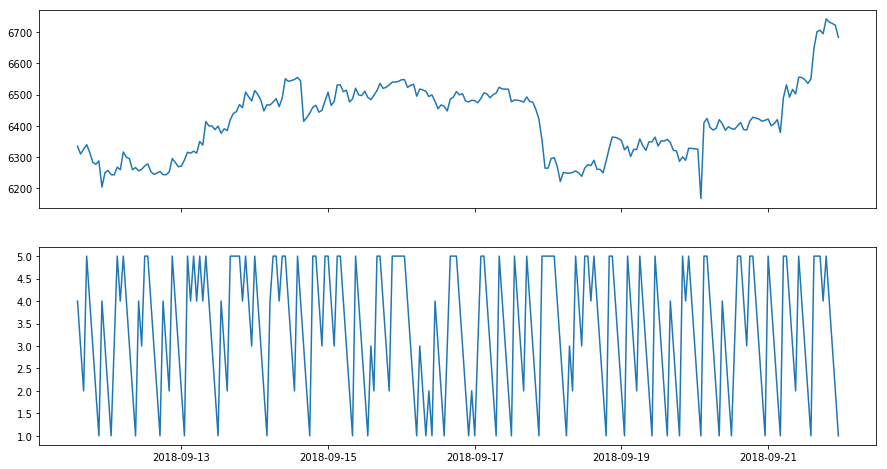

In [31]:
alpha1=dv1.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True, register_funcs={'RankPct':RankPct})
alpha1_plot = dv1.get_ts('alpha1_C', date_type='datetime')
close = dv1.get_ts('close', date_type='datetime')
plot_chart(close, alpha1_plot)

从因子图与价格图的关系可以看出，当价格发生下跌时，因子值也下跌，当价格发生上涨时，因子值也上涨，从这个角度看，因子值大致与价格涨跌状况保持一致。然而，当价格发生小幅度下跌和大幅度下跌时，因子的跌幅并没有与价格的跌幅有良好的相关性。从图中可以看出，当价格发生小幅下跌时，因子可能会大幅下跌，当价格发生大幅下跌时，因子的下跌幅度与价格发生小幅下跌时的因子下跌幅度差不多，说明该因子并不能很好的拟合价格的变化幅度。当价格上涨时也存在同样的问题。同时因子的变化与价格变化在时间上基本保持一致。

2.以下是画的Three-line strike, bearish反转因子，运用的数据是频率为1小时的BTCUSDT:binance

In [37]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [71]:
Threeline = dv1.add_formula('Threeline', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
ThreelineVolume = dv1.get_ts('Threeline', date_type='datetime')
ThreelineVolume[ThreelineVolume['BTCUSDT:binance']==100]

Field [Threeline] is overwritten.


symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


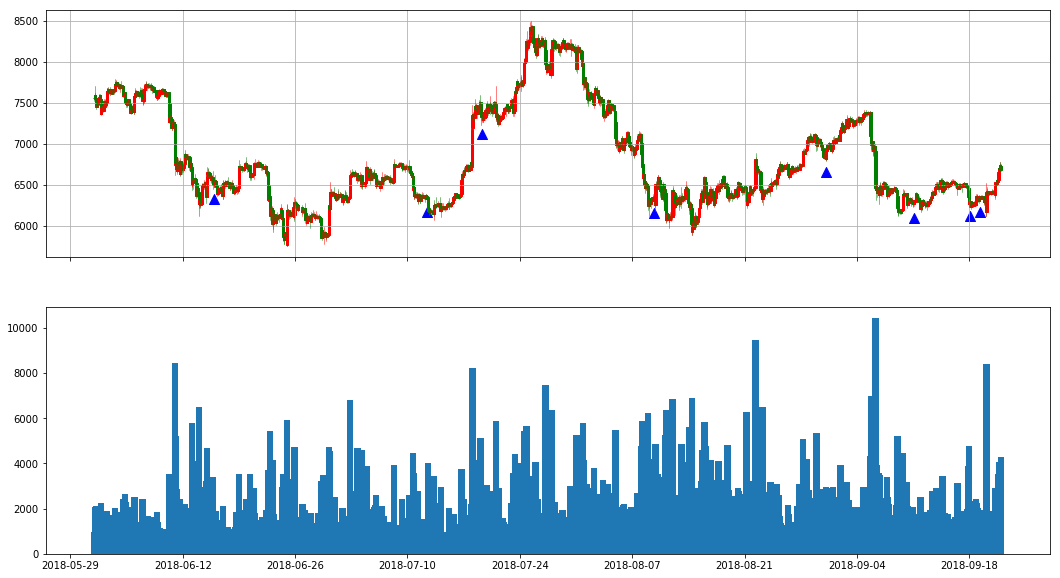

In [73]:
from matplotlib.pylab import date2num

data1H = btc['1H'].dropna().set_index('datetime')
data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

ThreelineVolumeX = ThreelineVolume[ThreelineVolume['BTCUSDT:binance']==100].index
ThreelineVolumeY = data1H.loc[ThreelineVolumeX].low-150
draw_candle(candle, ThreelineVolumeX, ThreelineVolumeY)

从蜡烛图和成交量可以看出，大幅上涨与大幅下跌同时伴随着巨大的成交量，而成交量小的地方，价格的波动相对较小。因此可以在判断价格是否会产生巨大反转或变化时，将成交量与因子相结合，如果反转因子出现的同时伴随着大于平均值的成交量，则可以进行相应的操作。如图所示，在该因子所标示的八个反转时间点中，有六个出现了明显反转，且都伴随着大于平均值的成交量。如果因子所示时间点价格下跌，则说明之后一段时间会出现下跌，如果因子所示时间点价格上涨，说明之后一段时间会出现上涨。

第五题

1.对于第一个因子，可以看到因子涨跌与价格的涨跌大致保持一致，因子上涨时，价格也发生上涨，因子下跌时，价格也发生下跌，但因子的波动幅度很大，即使价格只有小幅上涨或小幅下跌，因子也会发生明显的上涨或下跌。同时，因子的涨跌与价格的涨跌在时间上大致保持一致，所以当因子发生下跌时，卖出标的，当因子发生上涨时，买入标的。所以信号进出场假设是求因子的变化率，当此时变化率为正，且上一时期变化率为负时做多，当此时变化率为负，且上一期变化率为正时做空。也可以选取与该因子类似的（因子涨跌变化与价格涨跌变化基本一致，因子变化幅度足够大，且因子反转时间点与价格反转时间点大致相同的因子）其他多个因子，当出现上诉做多信号时，记1分，当出现上述做空信号时，记0分，然后对各因子打分相乘加总，大于60分做多，小于40分做空。

2.对于第二个因子，可以看到当因子所标注的时间点处股价上涨时，后续会有上涨趋势，当因子标记时间点出股价下跌时，后续会有下跌趋势，且通常情况下价格的大幅变动都伴随着成交量的增加，成交量大的时间点上价格变化幅度大，成交量小的时间点上价格变化幅度小，所以可以对因子标记的时间点处，结合成交量的大小来判断做空还是做多。所以信号进出场的假设是，当因子标记时间点处价格上涨，且此时成交量大于平均成交量时，做多，当因子标记的时间点处价格下跌，且此时成交量大于平均成交量时，做空。